# What is link prediction?

Link Prediction is the problem of predicting the existence of a relationship between nodes in a graph. In this guide, we will predict co-authorships using the link prediction machine learning model that was introduced in version 1.5.0 of the Graph Data Science Library.


In [1]:
from neo4j import GraphDatabase

# tag::imports[]
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# end::imports[]

In [2]:
#bolt_uri = "bolt://link-prediction-neo4j"
bolt_uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(bolt_uri, auth=("neo4j", "letmein"))

print(driver.address)

localhost:7687


## Citation Graph

In this guide, we’re going to use data from the DBLP Citation Network, which includes citation data from various academic sources. The full dataset is very large, but we’re going to use a subset that contains data from a few Software Development Conferences.

A screenshot of the available datasets is shown below:

<img src="https://neo4j.com/developer/graph-data-science/_images/citation-graph.png" width="800" height="400">


In [ ]:
We can import this dataset by running the following queries:

In [ ]:
query = """
CREATE CONSTRAINT ON (a:Article) ASSERT a.index IS UNIQUE;
CREATE CONSTRAINT ON (a:Author) ASSERT a.name IS UNIQUE;
CREATE CONSTRAINT ON (v:Venue) ASSERT v.name IS UNIQUE;
"""

with driver.session(database="neo4j") as session:
    print(session.run(query).consume().counters)

In [ ]:
query = """
CALL apoc.periodic.iterate(
  'UNWIND ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"] AS file
   CALL apoc.load.json("https://github.com/mneedham/link-prediction/raw/master/data/" + file)
   YIELD value
   RETURN value',
  'MERGE (a:Article {index:value.id})
   SET a += apoc.map.clean(value,["id","authors","references", "venue"],[0])
   WITH a, value.authors as authors, value.references AS citations, value.venue AS venue
   MERGE (v:Venue {name: venue})
   MERGE (a)-[:VENUE]->(v)
   FOREACH(author in authors |
     MERGE (b:Author{name:author})
     MERGE (a)-[:AUTHOR]->(b))
   FOREACH(citation in citations |
     MERGE (cited:Article {index:citation})
     MERGE (a)-[:CITED]->(cited))',
   {batchSize: 1000, iterateList: true}
);
"""

with driver.session(database="neo4j") as session:
    print(session.run(query).consume().counters)

In [ ]:
query = """
MATCH (a:Article)
WHERE not(exists(a.title))
DETACH DELETE a;
"""

with driver.session(database="neo4j") as session:
    print(session.run(query).consume().counters)

We can see what the imported citation graph looks like in the Neo4j Browser Visualization shown below:
    <img src="https://neo4j.com/developer/graph-data-science/_images/citation-graph-imported.svg" width="800" height="400">

## Building a co-author graph

The dataset doesn’t contain relationships between authors describing their collaborations, but we can infer them based on finding articles authored by multiple people. The code below creates a CO_AUTHOR relationship between authors that have collaborated on at least one article:


In [ ]:
query = """
CALL apoc.periodic.iterate(
  "MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
   WITH a1, a2, paper
   ORDER BY a1, paper.year
   RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
  "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
   SET coauthor.collaborations = collaborations",
  {batchSize: 100}
);
"""

with driver.session(database="neo4j") as session:
    print(session.run(query).consume().counters)

We create only one CO_AUTHOR relationship between authors that have collaborated, even if they’ve collaborated on multiple articles. We create a couple of properties on these relationships:
A year property that indicates the publication year of the first article on which the authors collaborated
A collaborations property that indicates how many articles on which the authors have collaborated
<img src="https://neo4j.com/developer/graph-data-science/_images/co-author-graph.svg" width="800" height="400">

## Link Prediction with the Graph Data Science Library

### Train and test datasets
To avoid data leakage, we need to split our graph into training and test sub graphs. The GDS Library has a Split Relationships algorithm that takes care of this for us.

Before we use that algorithm, let’s create an in-memory graph of our co-authors, by running the following query:

In [3]:
#List graphs
query = """
CALL gds.graph.list(

) YIELD
  graphName,
  database,
  nodeProjection,
  relationshipProjection,
  nodeQuery,
  relationshipQuery,
  nodeCount,
  relationshipCount,
  schema,
  degreeDistribution,
  density,
  creationTime,
  modificationTime,
  sizeInBytes,
  memoryUsage;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

""


In [4]:
# Drop in-memory graph if exists

query = """
CALL gds.graph.drop('linkpred', false) 
YIELD graphName;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

""


In [5]:
# Create in-memory graph Cypher
query = """
CALL gds.graph.create(
  'linkpred',
  'Author',
  {
    CO_AUTHOR: {
      orientation: 'UNDIRECTED'
    }
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,"{'Author': {'properties': {}, 'label': 'Author'}}","{'CO_AUTHOR': {'orientation': 'UNDIRECTED', 'a...",linkpred,80299,310448,295


And now we will use the Split Relationships algorithm to create both train and test in-memory graphs:

In [6]:
# Create test graph Cypher
query = """
CALL gds.alpha.ml.splitRelationships.mutate('linkpred', {
  relationshipTypes: ['CO_AUTHOR'],
  remainingRelationshipType: 'CO_AUTHOR_REMAINING',
  holdoutRelationshipType: 'CO_AUTHOR_TESTGRAPH',
  holdoutFraction: 0.2
})
YIELD createMillis, computeMillis, mutateMillis, relationshipsWritten;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,createMillis,computeMillis,mutateMillis,relationshipsWritten
0,0,165,1,310448


In [7]:
# Create training graph Cypher
query = """
CALL gds.alpha.ml.splitRelationships.mutate('linkpred', {
  relationshipTypes: ['CO_AUTHOR_REMAINING'],
  remainingRelationshipType: 'CO_AUTHOR_IGNORED_FOR_TRAINING',
  holdoutRelationshipType: 'CO_AUTHOR_TRAINGRAPH',
  holdoutFraction: 0.2
})
YIELD createMillis, computeMillis, mutateMillis, relationshipsWritten;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results  

,createMillis,computeMillis,mutateMillis,relationshipsWritten
0,0,75,0,248360


### Feature Engineering
Now it’s time to engineer some features which we’ll use to train our model. We are going to train a model that tries to identify missing links in the current graph, which might have happened because of misrecording of the authors who wrote a paper, resulting in missing collaborations. This is also referred to as transductive learning, and means that when we generate features we will generate them using the whole graph.

#### PageRank

The PageRank algorithm computes a score that indicates the transitive influence of an author. The higher the score, the more influential they are.

We can compute the PageRank for each author and store the result as a node property in the in-memory graph, by running the following query:


In [8]:
query = """
CALL gds.pageRank.mutate('linkpred',{
  maxIterations: 20,
  dampingFactor: 0.05,
  relationshipTypes: ["CO_AUTHOR"],
  mutateProperty: 'pagerank'
})
YIELD nodePropertiesWritten, mutateMillis, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results  

,nodePropertiesWritten,mutateMillis,createMillis,computeMillis
0,80299,1,1,213


### Triangle Count

The Triangle Count algorithm computes the number of triangles that a node forms. Three nodes A,B,C form a triangle if A is a co-author of B, B is a co-author of C, and C is a co-author of A.

We can compute the number of triangles for each author and store the results as a node property in the in-memory graph, by running the following query:


In [9]:
query = """
CALL gds.triangleCount.mutate('linkpred',{
  relationshipTypes: ["CO_AUTHOR"],
  mutateProperty: 'triangles'
})
YIELD nodePropertiesWritten, mutateMillis, nodeCount, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results  

,nodePropertiesWritten,mutateMillis,nodeCount,createMillis,computeMillis
0,80299,0,80299,1,177


### Fast Random Projection

The Fast Random Projection (FastRP) algorithm computes embeddings based on a node’s neighborhood. This means that two nodes that have similar neighborhoods should be assigned similar embedding vectors.

We can compute the FastRP embedding for each author and store the results as a node property in the in-memory graph, by running the following query:


In [10]:
query = """
CALL gds.fastRP.mutate('linkpred', {
    embeddingDimension: 250,
    relationshipTypes: ["CO_AUTHOR_REMAINING"],
    iterationWeights: [0, 0, 1.0, 1.0],
    normalizationStrength:0.05,
    mutateProperty: 'fastRP_Embedding'
})
YIELD nodePropertiesWritten, mutateMillis, nodeCount, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodePropertiesWritten,mutateMillis,nodeCount,createMillis,computeMillis
0,80299,0,80299,11,449


There is also a version of the **FastRP** algorithm that takes **node properties** into account. We can compute a FastRP embedding that uses the pagerank and triangles scores for each author and store the results as a node property in the in-memory graph, by running the following query:

In [11]:
query = """
CALL gds.beta.fastRPExtended.mutate('linkpred', {
  propertyDimension: 45,
  embeddingDimension: 250,
  featureProperties: ["pagerank", "triangles"],
  relationshipTypes: ["CO_AUTHOR_REMAINING"],
  iterationWeights: [0, 0, 1.0, 1.0],
  normalizationStrength:0.05,
  mutateProperty: 'fastRP_Embedding_Extended'
})
YIELD nodePropertiesWritten, mutateMillis, nodeCount, createMillis, computeMillis;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodePropertiesWritten,mutateMillis,nodeCount,createMillis,computeMillis
0,80299,0,80299,11,454


### Model Training and Evaluation

Now let’s build a model based on these features. The link prediction procedure trains a logistic regression model and evaluates it using the AUCPR metric.

We’ll train out first model using only the **fastRP_Embedding property**. We can do this by running the query below:


### Drop model if exists (Community Edition)

In [37]:
query = """
CALL gds.beta.model.list()
YIELD modelInfo
CALL gds.beta.model.drop(modelInfo.modelName)
YIELD modelInfo AS info
RETURN info;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

""


In [12]:
query = """
CALL gds.alpha.ml.linkPrediction.train('linkpred', {
  trainRelationshipType: 'CO_AUTHOR_TRAINGRAPH',
  testRelationshipType: 'CO_AUTHOR_TESTGRAPH',
  modelName: 'model-only-embedding',
  featureProperties: ['fastRP_Embedding'],
  validationFolds: 5,
  classRatio: 1.0,
  randomSeed: 2,
  params: [
    {penalty: 0.25, maxIterations: 1000},
    {penalty: 0.5, maxIterations: 1000},
    {penalty: 1.0, maxIterations: 1000},
    {penalty: 0.0, maxIterations: 1000}
  ]
})
YIELD trainMillis, modelInfo
RETURN trainMillis,
       modelInfo.bestParameters AS winningModel,
       modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
       modelInfo.metrics.AUCPR.test AS testGraphScore;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,trainMillis,winningModel,trainGraphScore,testGraphScore
0,98344,"{'maxIterations': 1000, 'penalty': 0.0}",0.967,0.938


#### If using py2neo

In [15]:
from py2neo import Graph
graph = Graph("bolt://localhost:7687", auth=("neo4j", "letmein"))

In [18]:
graph.run("""
CALL gds.alpha.ml.linkPrediction.train('linkpred', {
  trainRelationshipType: 'CO_AUTHOR_TRAINGRAPH',
  testRelationshipType: 'CO_AUTHOR_TESTGRAPH',
  modelName: 'model-only-embedding',
  featureProperties: ['fastRP_Embedding'],
  validationFolds: 5,
  classRatio: 1.0,
  randomSeed: 2,
  params: [
    {penalty: 0.25, maxIterations: 1000},
    {penalty: 0.5, maxIterations: 1000},
    {penalty: 1.0, maxIterations: 1000},
    {penalty: 0.0, maxIterations: 1000}
  ]
})
YIELD trainMillis, modelInfo
RETURN trainMillis,
       modelInfo.bestParameters AS winningModel,
       modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
       modelInfo.metrics.AUCPR.test AS testGraphScore;
""").to_data_frame()

,trainMillis,winningModel,trainGraphScore,testGraphScore
0,106364,"{'maxIterations': 1000, 'penalty': 0.0}",0.965,0.941




This looks good - the model is very good at predicting missing relationships in the graph.

One tweak we could make is to specify the linkFeatureCombiner in the params used to train the model. By default, the L2 feature combiner is used, which means that the (feature(nodeA) - feature(nodeB))^2 formula is used to generate features for each pair of nodes. If we use HADAMARD instead, the feature(nodeA) * feature(nodeB) formula is used instead. With the HADAMARD combiner, we are saying that there’s a higher probability of a relationship existing between two nodes that have a score of 100 than between two nodes that have a score of 0.

We can train a model using this combiner by running the following query:


In [ ]:
## Drop the previous model, if using community edition
query = """
CALL gds.beta.model.list()
YIELD modelInfo
CALL gds.beta.model.drop(modelInfo.modelName)
YIELD modelInfo AS info
RETURN info;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

In [ ]:
query = """
CALL gds.alpha.ml.linkPrediction.train('linkpred', {
  trainRelationshipType: 'CO_AUTHOR_TRAINGRAPH',
  testRelationshipType: 'CO_AUTHOR_TESTGRAPH',
  modelName: 'model-only-embedding-hadamard',
  featureProperties: ['fastRP_Embedding'],
  validationFolds: 5,
  classRatio: 1.0,
  randomSeed: 2,
  params: [
    {penalty: 0.25, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'},
    {penalty: 0.5, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'},
    {penalty: 1.0, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'},
    {penalty: 0.0, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'}
  ]
})
YIELD modelInfo
RETURN modelInfo.bestParameters AS winningModel,
       modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
       modelInfo.metrics.AUCPR.test AS testGraphScore;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

That’s slightly better than our previous model.

We can now train models based on combinations of features, by running the following query:

In [ ]:
## Drop the previous model, if using community edition
query = """
CALL gds.beta.model.list()
YIELD modelInfo
CALL gds.beta.model.drop(modelInfo.modelName)
YIELD modelInfo AS info
RETURN info;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

In [ ]:
query = """
UNWIND [
  ["fastRP_Embedding_Extended"],
  ["fastRP_Embedding", "pagerank", "triangles"],
  ["fastRP_Embedding", "pagerank"],
  ["fastRP_Embedding", "triangles"],
  ["fastRP_Embedding"]
] AS featureProperties
CALL gds.alpha.ml.linkPrediction.train('linkpred', {
  trainRelationshipType: 'CO_AUTHOR_TRAINGRAPH',
  testRelationshipType: 'CO_AUTHOR_TESTGRAPH',
  modelName: 'model-' + apoc.text.join(featureProperties, "-"),
  featureProperties: featureProperties,
  validationFolds: 5,
  classRatio: 1.0,
  randomSeed: 2,
  params: [
    {penalty: 0.25, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'},
    {penalty: 0.5, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'},
    {penalty: 1.0, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'},
    {penalty: 0.0, maxIterations: 1000, linkFeatureCombiner: 'HADAMARD'}
  ]
})
YIELD modelInfo
RETURN modelInfo;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

We can return a stream of all the models and their accuracies by running the following query:

In [ ]:
# In non community edition only this will run
query = """
CALL gds.beta.model.list()
YIELD modelInfo
RETURN modelInfo.modelName AS modelName,
       modelInfo.bestParameters AS winningModel,
       modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
       modelInfo.metrics.AUCPR.test AS testGraphScore
ORDER BY testGraphScore DESC;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

Interestingly the best model combines the fastRP_Embedding and pagerank features, but the model based on the fastRP_Embedding_Extended embedding that also includes the pagerank features does much worse.

We’ve trained a reasonably good model that can predict potential mislabelling in citations

### Mutate


In this example we will see how to use a trained model to predict new relationships in your in-memory graph. In order to do this, we must first have an already trained model registered in the Model Catalog. We will use the model which we trained in the train example which we gave the name 'model-only-embedding'.

We must also make sure that we do not include any of the relationships from the train or test graphs, which we do by specifying a relationship filter for the original relationship type 'CO_AUTHOR'.

We specified threshold to filter out predictions with probability less than 45%, and topN to further limit output to the top 5 relationships. Because we are using the UNDIRECTED orientation, we will write twice as many relationships to the in-memory graph.


In [14]:
query = """
CALL gds.alpha.ml.linkPrediction.predict.mutate('linkpred', {
  relationshipTypes: ['CO_AUTHOR'],
  modelName: 'model-only-embedding',
  mutateRelationshipType: 'CO_AUTHOR_PREDICTED',
  topN: 5,
  threshold: 0.45
}) YIELD relationshipsWritten;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,relationshipsWritten
0,10


In order to analyze our predicted relationships we will write them back to Neo4j:

In [15]:
query = """
CALL gds.graph.writeRelationship('linkpred', 'CO_AUTHOR_PREDICTED', 'probability')
YIELD relationshipsWritten, propertiesWritten;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,relationshipsWritten,propertiesWritten
0,10,10


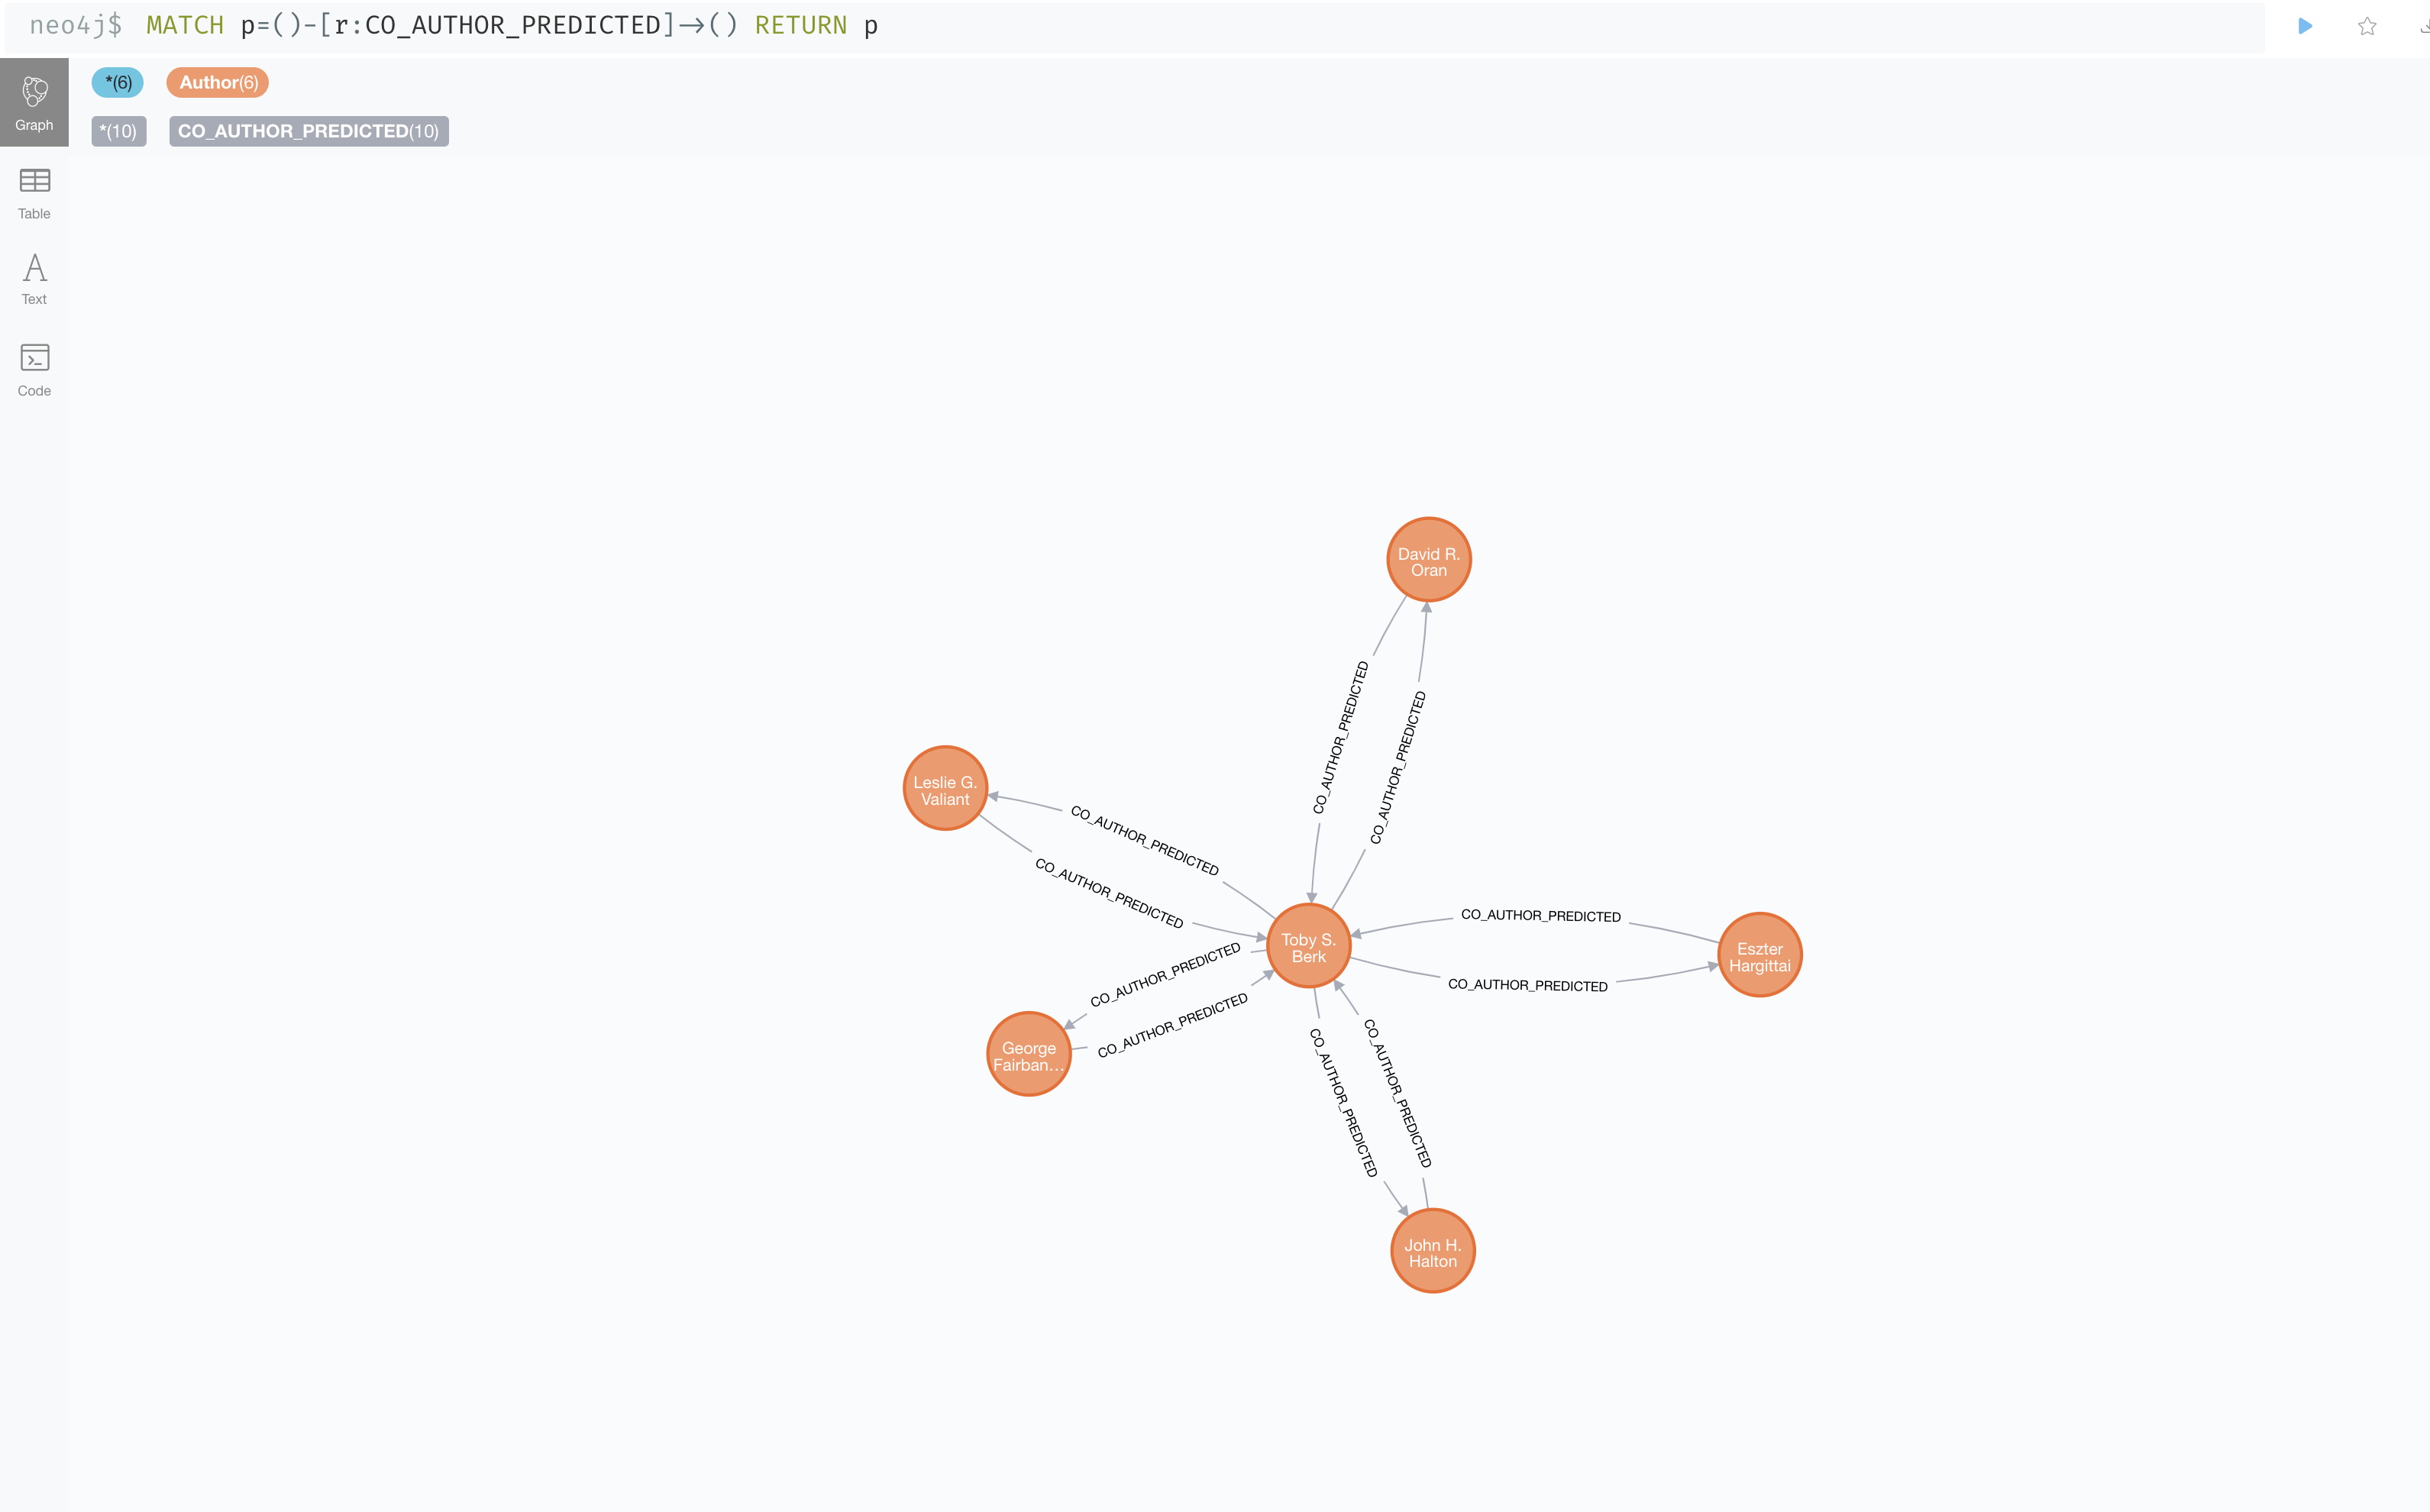